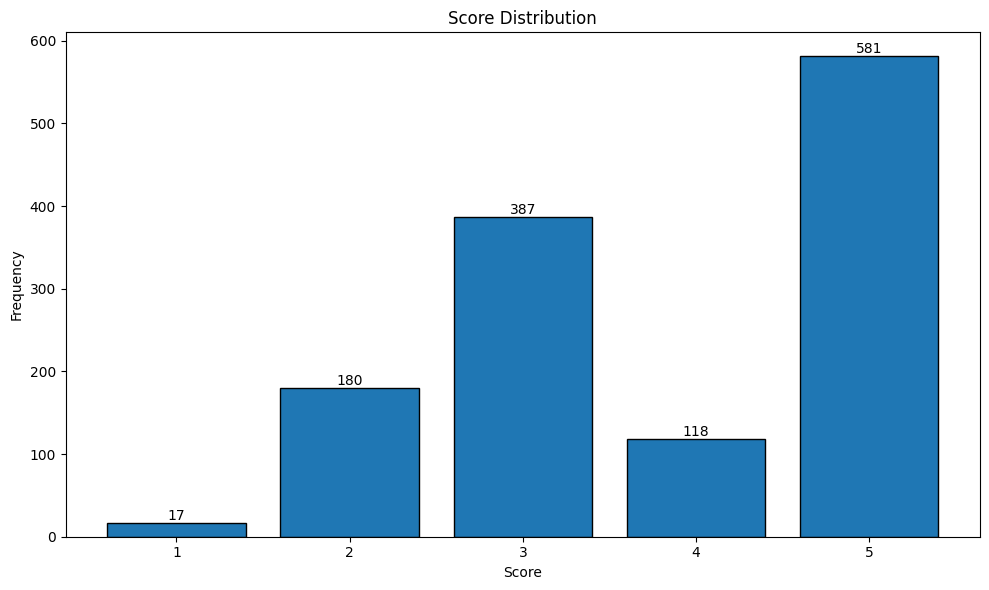

In [1]:
import csv
import matplotlib.pyplot as plt
import os
import json


# 读取 /home/zjusst/qms/osgensis/rating.csv
rating_csv_path = "/home/zjusst/qms/osgensis/rating_all.csv"
with open(rating_csv_path, "r") as f:
    reader = csv.reader(f)
    # 跳过第一行
    next(reader)
    rating_data = [row for row in reader]

scores = [row[2] for row in rating_data]
# 统计每个分数的频率
score_counts = {}
for score in scores:
    if score not in score_counts:
        score_counts[score] = 0
    score_counts[score] += 1

# 绘制柱状图，并在柱子上标上数量
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
scores = ['1', '2', '3', '4', '5']
counts = [score_counts.get(score, 0) for score in scores]
bars = plt.bar(scores, counts, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')

# 在柱子上标上数量
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [2]:
rating_data[0]

['/home/zjusst/qms/osgensis/total_trajs/traj_0000.json',
 'The agent starts from an already-logged-in Magento Admin Dashboard, correctly reasons that it should log out and then log in as the customer, and performs plausible logout and login steps. However, it logs back into the *admin* login form instead of a customer-facing site and never attempts to switch context to a storefront/customer login. After one failed login (likely due to wrong context), it gives up and issues a `stop`, declaring it must “wait and try again later” instead of retrying or exploring other paths (e.g., storefront URL, different login page) to reach "My Wish List." No navigation toward any "My Account" or "My Wish List" section occurs. The sequence is somewhat coherent but ends prematurely without meaningful progress toward the actual wish list goal.',
 '2']

In [5]:
filepath_to_rating_data = {}
for row in rating_data:
    filepath = row[0]
    score = int(row[2])
    filepath_to_rating_data[filepath] = score

len(filepath_to_rating_data)

1283

In [6]:
filepath_to_rating_data['/home/zjusst/qms/osgensis/total_trajs/traj_0000.json']

2

In [ ]:
import random

resample_file_paths = []
# 按照 filepath_to_rating_data 的评分加权随机采样，采样 1283 条轨迹

# 获取所有文件路径和对应的评分
filepaths = list(filepath_to_rating_data.keys())
weights = [filepath_to_rating_data[fp] for fp in filepaths]

# 使用加权随机采样，采样 1283 条轨迹
# random.choices 会根据权重进行采样，权重越高被选中的概率越大
resample_file_paths = random.choices(filepaths, weights=weights, k=1283)
len(resample_file_paths)

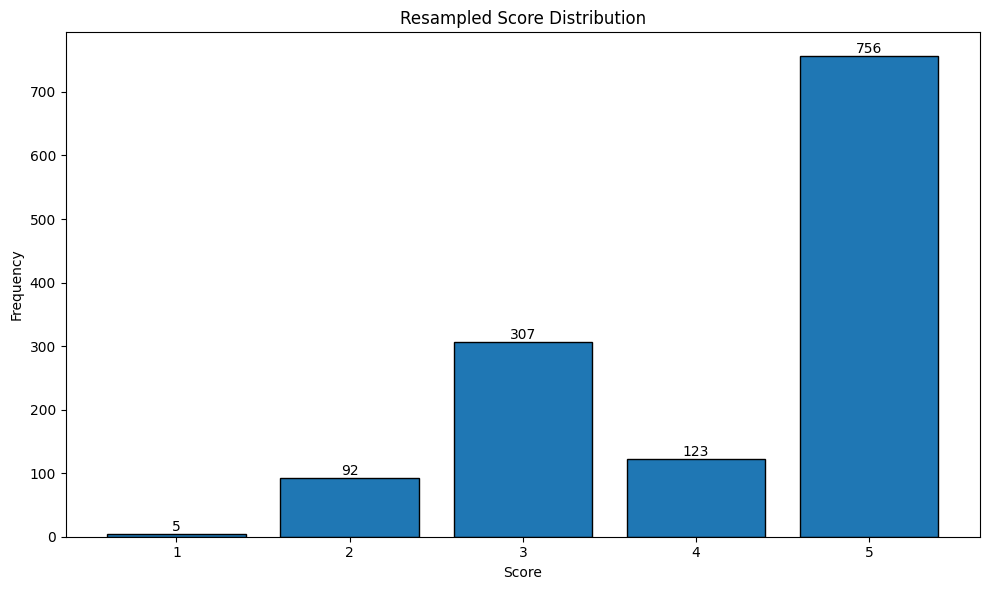

In [8]:
import json
from collections import Counter

# 1. 统计评分分布
resample_scores = [filepath_to_rating_data[fp] for fp in resample_file_paths]
score_counts = Counter(resample_scores)

# 绘制评分分布图
plt.figure(figsize=(10, 6))
scores = ['1', '2', '3', '4', '5']
counts = [score_counts.get(int(score), 0) for score in scores]
bars = plt.bar(scores, counts, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Resampled Score Distribution')

# 在柱子上标上数量
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
unique_paths = set(resample_file_paths)
duplicate_count = len(resample_file_paths) - len(unique_paths)
duplicate_rate = duplicate_count / len(resample_file_paths) * 100

print(f"总采样数量: {len(resample_file_paths)}")
print(f"唯一轨迹数量: {len(unique_paths)}")
print(f"重复个数: {duplicate_count}")
print(f"重复率: {duplicate_rate:.2f}%")


总采样数量: 1283
唯一轨迹数量: 774
重复个数: 509
重复率: 39.67%


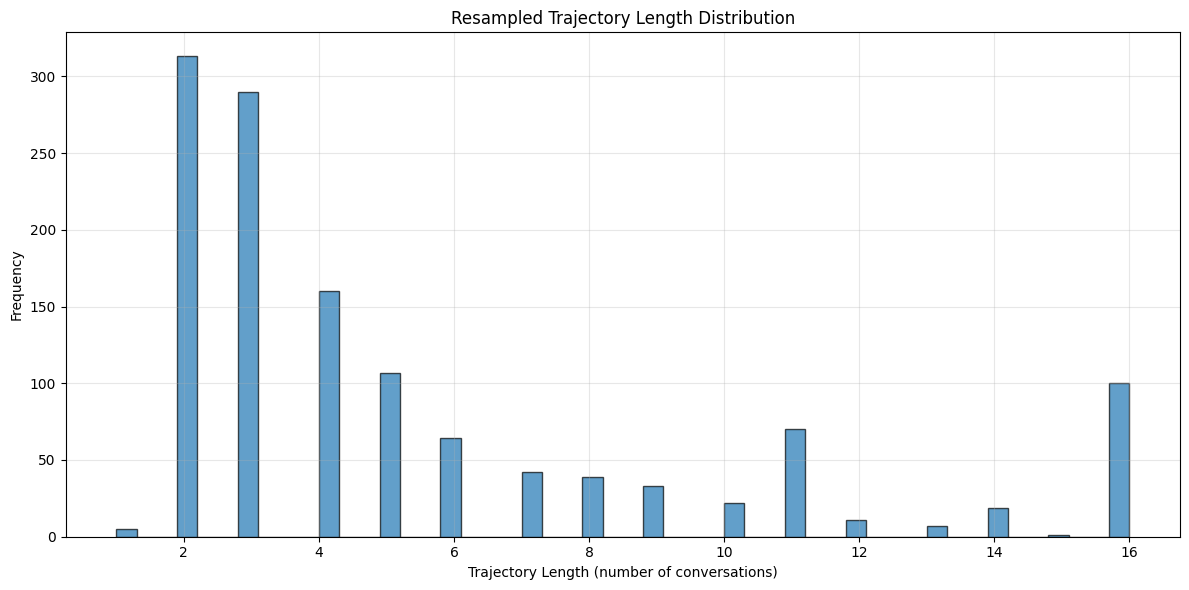

In [ ]:
traj_lengths = []
for filepath in resample_file_paths:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            traj_data = json.load(f)
            # 计算轨迹长度：每个任务对象的 conversations 数量
            length = len(traj_data)
            traj_lengths.append(length)
    except Exception as e:
        print(f"读取文件 {filepath} 时出错: {e}")
        

plt.figure(figsize=(12, 6))
plt.hist(traj_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Trajectory Length (number of conversations)')
plt.ylabel('Frequency')
plt.title('Resampled Trajectory Length Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# 打印长度统计信息
print(f"\n轨迹长度统计:")
print(f"最小长度: {min(traj_lengths)}")
print(f"最大长度: {max(traj_lengths)}")
print(f"平均长度: {sum(traj_lengths) / len(traj_lengths):.2f}")
print(f"中位数长度: {sorted(traj_lengths)[len(traj_lengths) // 2]}")


轨迹长度统计:
最小长度: 1
最大长度: 16
平均长度: 5.50
中位数长度: 4


In [24]:
llama_train_planning_data = []


for filepath in resample_file_paths:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            traj_data = json.load(f)
            for step in traj_data:
                llama_train_planning_data.append({
                    "messages":[
                        {
                            "role": "user",
                            "content": step["conversations"][0]['value'].replace("<image>\n", "")
                        },
                        {
                            "role": "assistant",
                            "content": step["conversations"][1]['value']
                        }
                    ]
                })
    except Exception as e:
        print(f"读取文件 {filepath} 时出错: {e}")

len(llama_train_planning_data)

7057

In [25]:
# 保存到 /home/zjusst/qms/osgensis/llama_data/os_genesis_web_training_plannings_resampled.json
with open('/home/zjusst/qms/osgensis/llama_data/os_genesis_web_training_plannings_resampled.json', 'w', encoding='utf-8') as f:
    json.dump(llama_train_planning_data, f, ensure_ascii=False, indent=4)


In [41]:
import re

llama_train_action_data = []

user_prompt_template = """You are an intelligent agent completing web-based tasks. I will provide you with available actions, a screenshot with its corresponding accessibility tree, and a low-level thought.

**Available Actions**  
- `click [id]`: This action clicks on an element with a specific id on the webpage.
- `type [id] [content] [press_enter_after=0|1]`: Use this to type the content into the field with id. By default, the "Enter" key is pressed after typing unless press_enter_after is set to 0.
- `hover [id]`: Hover over an element with id.
- `press [key_comb]`:  Simulates the pressing of a key combination on the keyboard (e.g., Ctrl+v).
- `scroll [direction=down|up]`: Scroll the page up or down. 
- `new_tab`: Open a new, empty browser tab.
- `tab_focus [tab_index]`: Switch the browser's focus to a specific tab using its index.
- `close_tab`: Close the currently active tab. 
- `goto [url]`: Navigate to a specific URL.
- `go_back`: Navigate to the previously viewed page.
- `go_forward`: Navigate to the next page (if a previous 'go_back' action was performed).
- `stop [answer]`: Issue this action when you believe the task is complete. If the objective is to find a text-based answer, provide the answer in the bracket. If you believe the task is impossible to complete, provide the answer as "N/A" in the bracket.

{a11y_tree}
Low-level thought: {low_level_thought}

Please generate the action inside ˋˋˋˋˋˋ for the next step."""

for filepath in resample_file_paths:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            traj_data = json.load(f)
            for step in traj_data:
                lines = step['conversations'][0]['value'].replace("<image>\n", "").split('\n')
                a11y_tree_list = []
                a11y_flag = False
                for line in lines:
                    if line.startswith('Accessibility tree:'):
                        a11y_flag = True
                    elif line.startswith('Action History:'):
                        a11y_flag = False

                    if a11y_flag:
                        a11y_tree_list.append(line)

                a11y_tree = '\n'.join(a11y_tree_list)

                # 关于 low_level_thought，从 data['conversations'][1]['value'] 中提取，找到 “In summary, the next action I will perform is” 前面的内容
                try:
                    if not step['conversations'][1]['value']:
                        print(f"No action found for data: {filepath}")
                        continue

                    # if "I'm unable to watch or" in step['conversations'][1]['value']:

                    low_level_thought = step['conversations'][1]['value'].split('In summary, the next action I will perform is')[0]
                    action_str = step['conversations'][1]['value'].split('In summary, the next action I will perform is')[1]

                    # 找到 `````` 包裹的部分
                    action_match = re.search(r'```(.*?)```', action_str, re.DOTALL)
                    if action_match:
                        action = action_match.group(1).strip()
                    else:
                        action = action_str.strip()

                    action = "```" + action + "```"
                except:
                    # raise ValueError(f"No low-level thought found for data: {data['conversations'][1]['value']}")
                    print(f"can not find action for {filepath}, skip....")
                    continue


                temp_data = {}
                temp_data['messages'] = []
                temp_data['messages'].append({
                    "role": "user",
                    "content": user_prompt_template.format(a11y_tree=a11y_tree, low_level_thought=low_level_thought)
                })
                temp_data['messages'].append({
                    "role": "assistant",
                    "content": action
                })
                llama_train_action_data.append(temp_data)
                
    except Exception as e:
        print(f"读取文件 {filepath} 时出错: {e}")

len(llama_train_action_data)

No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0956.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0122.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0281.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0274.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0168.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0363.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0224.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0008.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0733.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0105.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0321.json
No action found for data: /home/zjusst/qms/osgensis/total_trajs/traj_0027.json
No action found for data: /home/zjusst/qms/osgensis/

6815

In [45]:
print(llama_train_action_data[0]['messages'][0]['content'])

You are an intelligent agent completing web-based tasks. I will provide you with available actions, a screenshot with its corresponding accessibility tree, and a low-level thought.

**Available Actions**  
- `click [id]`: This action clicks on an element with a specific id on the webpage.
- `type [id] [content] [press_enter_after=0|1]`: Use this to type the content into the field with id. By default, the "Enter" key is pressed after typing unless press_enter_after is set to 0.
- `hover [id]`: Hover over an element with id.
- `press [key_comb]`:  Simulates the pressing of a key combination on the keyboard (e.g., Ctrl+v).
- `scroll [direction=down|up]`: Scroll the page up or down. 
- `new_tab`: Open a new, empty browser tab.
- `tab_focus [tab_index]`: Switch the browser's focus to a specific tab using its index.
- `close_tab`: Close the currently active tab. 
- `goto [url]`: Navigate to a specific URL.
- `go_back`: Navigate to the previously viewed page.
- `go_forward`: Navigate to the n

In [44]:
# 保存到 /home/zjusst/qms/osgensis/llama_data/os_genesis_web_training_actions_resampled.json
with open('/home/zjusst/qms/osgensis/llama_data/os_genesis_web_training_actions_resampled.json', 'w', encoding='utf-8') as f:
    json.dump(llama_train_action_data, f, ensure_ascii=False, indent=4)


In [46]:
all_data = llama_train_planning_data + llama_train_action_data
print(len(all_data))
# 保存到 /home/zjusst/qms/osgensis/llama_data/os_genesis_web_training_all_resampled.json
with open('/home/zjusst/qms/osgensis/llama_data/os_genesis_web_training_mix_resampled.json', 'w', encoding='utf-8') as f:
    json.dump(all_data, f, ensure_ascii=False, indent=4)



13872
